In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.jobstatus import JobStatus
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker

In [23]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [24]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="e3d76332de187f9b82dbd1904444ae8aaca1b80ed6fa6b8ae43d3b8f2641c0eea75884a158e0208d8d46c6d03551260f840427bfee34f4e323e13454fbf86fdf",
    overwrite=True,
    set_as_default=True,
)
service = QiskitRuntimeService(channel="ibm_quantum")

/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_87907/3590335105.py:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


In [25]:
jobID = "d0e8ndn36cs0008qw640"  #  <<<<<<<<<<<<   <<<<<<<<<<<<<   <<<<<<<<<<<<<   Replace with your job ID
retrieved_job = service.job(job_id=jobID)
status = retrieved_job.status()
print(f"Job Status: {status}")
if status == 'DONE':
        print("Job finished successfully. Getting results...")
        # Set a timeout (in seconds) for retrieving results, optional
        result = retrieved_job.result(timeout=300)
        print("Results retrieved successfully.")

Job Status: DONE
Job finished successfully. Getting results...
Results retrieved successfully.


Determined number of measured bits: 6
{44: 0.0168, 25: 0.0162, 33: 0.016, 36: 0.0177, 34: 0.0133, 27: 0.0191, 32: 0.0128, 26: 0.022, 29: 0.0118, 14: 0.0129, 56: 0.0171, 37: 0.0186, 59: 0.0135, 30: 0.0152, 18: 0.0185, 1: 0.0148, 60: 0.0212, 28: 0.0167, 6: 0.0153, 46: 0.0137, 9: 0.0164, 52: 0.0158, 63: 0.0137, 4: 0.015, 62: 0.0157, 23: 0.0186, 10: 0.0129, 57: 0.0137, 13: 0.0164, 20: 0.0103, 53: 0.0125, 19: 0.0212, 21: 0.011, 31: 0.0134, 24: 0.0187, 45: 0.0154, 0: 0.0139, 41: 0.017, 3: 0.0193, 40: 0.018, 2: 0.0153, 8: 0.0162, 38: 0.0171, 49: 0.0124, 17: 0.0136, 35: 0.0138, 39: 0.0171, 50: 0.013, 5: 0.0183, 54: 0.0175, 61: 0.0147, 42: 0.0147, 7: 0.0177, 12: 0.0201, 58: 0.0159, 11: 0.017, 47: 0.0156, 43: 0.0142, 55: 0.0156, 51: 0.0142, 15: 0.0143, 16: 0.013, 48: 0.0126, 22: 0.014}
Result bitstring: [0, 1, 0, 1, 1, 0]


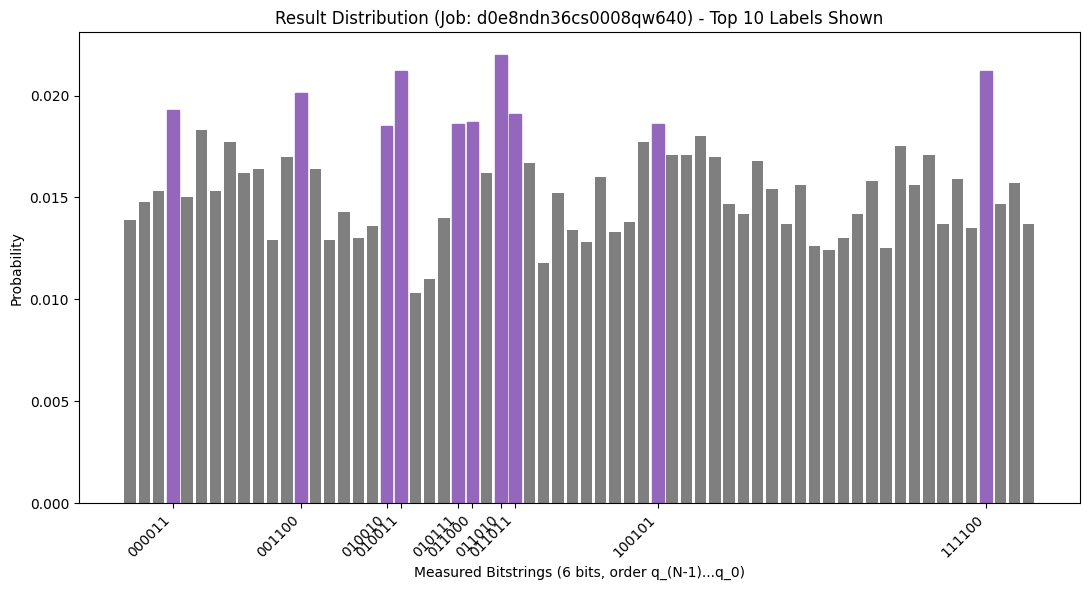

In [26]:
#Following taken from https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
#For the specific maxcut problemin the example, will probably need diferent result processing when the variables represent things other than nodes
counts_int = result[0].data.meas.get_int_counts()
counts_bin = result[0].data.meas.get_counts()

first_key = next(iter(counts_bin))
num_bits = len(first_key)
print(f"Determined number of measured bits: {num_bits}")

shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_bits) 
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)


#plotting \/ \/ \/
matplotlib.rcParams.update({"font.size": 10})

# --- User Specification ---
# Define how many top results to highlight and label
num_to_highlight_and_label = 10
# --- End User Specification ---

final_bits_to_plot = final_distribution_bin

# Sort by bitstring key for consistent bar order
sorted_keys = sorted(final_bits_to_plot.keys())
sorted_values = [final_bits_to_plot[key] for key in sorted_keys]

# Find the indices corresponding to the top probability values IN THE SORTED LIST
# Ensure we don't ask for more labels than available results
actual_num_to_highlight = min(num_to_highlight_and_label, len(sorted_values))

if actual_num_to_highlight > 0:
    # Get indices of the top N probabilities in the sorted list
    top_indices_sorted = np.argsort(sorted_values)[-actual_num_to_highlight:][::-1]
    # Keep them sorted by index for cleaner tick placement
    top_indices_sorted = sorted(top_indices_sorted)
else:
    top_indices_sorted = [] # No indices to highlight/label

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot bars using numerical indices for x-positions
x_positions = np.arange(len(sorted_keys))
bars = ax.bar(x_positions, sorted_values, color="tab:grey")

# Highlight the top bars
for idx in top_indices_sorted:
    bars[idx].set_color("tab:purple")

# --- Set selective X-axis ticks and labels ---
if top_indices_sorted: # Only set ticks if there are results to highlight
    tick_locations = [x_positions[i] for i in top_indices_sorted]
    tick_labels = [sorted_keys[i] for i in top_indices_sorted]

    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
else: # If no results or none to highlight, remove all ticks/labels
    ax.set_xticks([])
    ax.set_xticklabels([])


# --- Add Titles and Labels ---
title_str = f"Result Distribution (Job: {jobID})"
if actual_num_to_highlight > 0 and len(sorted_keys) > actual_num_to_highlight:
        title_str += f" - Top {actual_num_to_highlight} Labels Shown"
plt.title(title_str)
plt.xlabel(f"Measured Bitstrings ({num_bits} bits, order q_(N-1)...q_0)") # Label still describes format
plt.ylabel("Probability")
plt.ylim(bottom=0) # Ensure y-axis starts at 0
plt.tight_layout()
plt.show()


